# Evaluación de la  Calidad de  Aire en  el Municipio de Soacha

Objetivo : generar un mapa  donde que nos permita evaluar los  niveles de calidad  de aire frente  a la norma en un mapa de  coropletas  para  el municipio de Soacha , de  acuerdo  a la normatividad en Colombia  los niveles de  PM 2.5  a partir  de la media de cada  Estación ( monitor Bajo Costo).

En Colombia, la normativa que regula los límites máximos permisibles de material particulado PM2.5 en el aire ambiente es la Resolución 2254 de 2017 del Ministerio de Ambiente y Desarrollo Sostenible. Esta resolución establece los estándares de calidad del aire para proteger la salud humana y el ambiente.
Según esta norma, los límites para PM2.5 son:
•	Promedio anual: 25 µg/m³
•	Promedio de 24 horas: 50 µg/m³ (no debe superarse más de 4 veces por año)


se  define  utilizar el  diagrama de Voronoi,    

#  Descripción del Script  - uso de Diagramas de Voronoi

En el script se siguen estos pasos: 
- se cargan y preprocesan los datos (incluyendo las coordenadas geográficas y lecturas de PM2.5), 
- se reproyectan al sistema de referencia adecuado y, a partir de las posiciones de las estaciones, se construyen las regiones de Voronoi.
- Luego, estas regiones se recortan al límite del municipio de Soacha para asegurar que el análisis se haga únicamente en el área de interés.
- Finalmente, cada polígono se clasifica en “Cumple” o “No cumple” de acuerdo a la normativa (Resolución 2254 de 2017), que establece como límite el valor promedio anual de 25 µg/m³ para PM2.5.

# Por  que Poligonos  de Vonoi en lugar de BufferDiagrama de Voronoi

Tanto los **diagramas de Voronoi** como los **buffers** se usan para analizar proximidad espacial, tienen enfoques y propósitos distintos:

### **Buffer**
- **Qué hace:** Crea una zona alrededor de un objeto (punto, línea o polígono) a una distancia fija.
- **Uso típico:** Evaluar influencia o impacto dentro de un radio determinado (por ejemplo, zonas de afectación alrededor de una carretera).
- **Forma:** Siempre circular (en puntos) o paralela (en líneas), con una distancia constante.

### **Diagrama de Voronoi**
- **Qué hace:** Divide el espacio en regiones donde cada punto pertenece a la celda del punto más cercano.
- **Uso típico:** Asignar áreas de influencia exclusivas a puntos (como estaciones de monitoreo o centros de salud).
- **Forma:** Polígonos irregulares que se ajustan a la distribución espacial de los puntos.

### Diferencia clave:
- El **buffer** se basa en una **distancia fija**, mientras que el **Voronoi** se basa en la **distancia relativa entre puntos**.
- En un análisis de calidad del aire, por ejemplo, un **buffer** te diría qué zonas están dentro de 1 km de una estación, mientras que un **Voronoi** te diría qué zonas están **más cerca de una estación que de cualquier otra**.


Fusion inicial:
                    Estación                             Coordenadas  \
0  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
1  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
2  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
3  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
4  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   

                   date    PM25  Humidity  Temperature  
0  2025-03-01T01:00:00Z  17.745    77.936        18.17  
1  2025-03-01T02:00:00Z  18.760    78.760        18.00  
2  2025-03-01T03:00:00Z  13.200    80.000        18.00  
3  2025-03-01T04:00:00Z     NaN       NaN          NaN  
4  2025-03-01T05:00:00Z  13.000    80.000        18.00  
Tras separar coordenadas:
                    Estación                             Coordenadas  \
0  SAM_IE_BuenosAires_306e73  4.5652591030570475, -74.18809170278799   
1  SAM_IE_BuenosAires_306e73  4.5652591

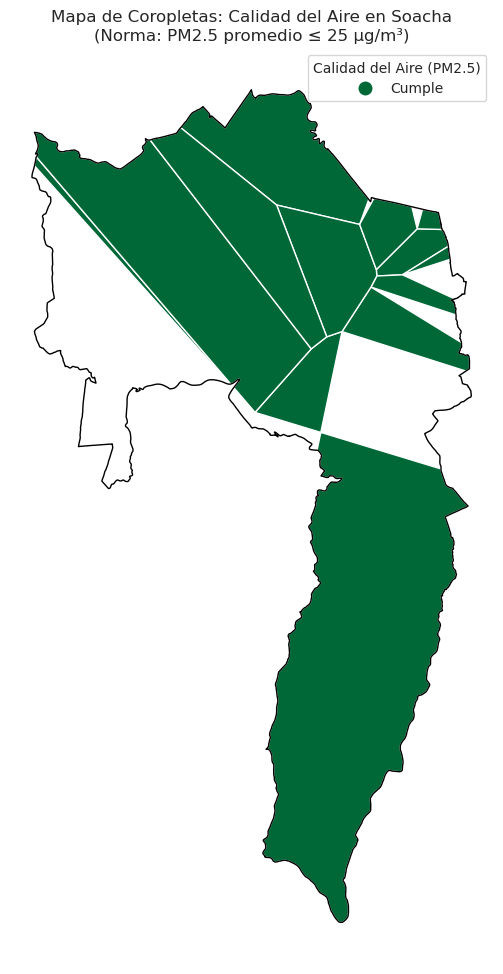

In [1]:
# =============================================================================
# 0. Importar libreríaspdf
# =============================================================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

from pathlib import Path
from shapely.geometry import Point, Polygon
import libpysal as ps
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster

# Para el diagrama de Voronoi:
from scipy.spatial import Voronoi

# =============================================================================
# 1. Cargar y preparar datos
# =============================================================================
# Rutas a archivos
root_folder = "/notebooks/"
MON_path = root_folder + "data_MAR_1.csv"              # Datos de monitoreo de sensores
excel_path = root_folder + "Coordenadas_Instituciones.xlsx"   # Coordenadas de instituciones
SHAPE_MUN = root_folder + "municipios_colombia.shp"         # Shapefile de municipios
SHAPE_REDVIAL = root_folder + "RedVial.shp"                 # Capa de red vial
SHAPE_SUELO = root_folder + "Usos_Suelo_Urbano_POT._Municipio_de_Soacha._2000_(capa).shp"  # Capa de suelo

# Cargar shapefiles
gdf_mun = gpd.read_file(SHAPE_MUN)
gdf_road = gpd.read_file(SHAPE_REDVIAL)
gdf_suelo = gpd.read_file(SHAPE_SUELO)

# Cargar coordenadas desde Excel y CSV de monitoreo
df_coord = pd.read_excel(excel_path, sheet_name="Hoja1")
df_moni = pd.read_csv(MON_path)
df_moni.rename(columns={"station": "Estación"}, inplace=True)

# Fusionar por "Estación"
datos_combinados = pd.merge(df_coord, df_moni, on="Estación", how="inner")
print("Fusion inicial:")
print(datos_combinados.head())

# Separar la columna 'Coordenadas' en 'Latitud' y 'Longitud'
datos_combinados[['Latitud', 'Longitud']] = datos_combinados['Coordenadas'].str.split(',', expand=True)
datos_combinados['Latitud'] = datos_combinados['Latitud'].astype(float)
datos_combinados['Longitud'] = datos_combinados['Longitud'].astype(float)
print("Tras separar coordenadas:")
print(datos_combinados.head())

# Agregar estadísticas por estación (por ejemplo, promedio PM2.5)
station_summary = df_moni.groupby("Estación").agg({
    "PM25": ["mean", "std", "min", "max"],
    "Humidity": ["mean", "std", "min", "max"],
    "Temperature": ["mean", "std", "min", "max"]
}).reset_index()

station_summary.columns = [
    "Estación",
    "PM25_mean", "PM25_std", "PM25_min", "PM25_max",
    "Humidity_mean", "Humidity_std", "Humidity_min", "Humidity_max",
    "Temperature_mean", "Temperature_std", "Temperature_min", "Temperature_max"
]

print("Resumen estadístico por estación:")
print(station_summary.head())

# Extraer coordenadas únicas por estación
coord_estaciones = datos_combinados[["Estación", "Latitud", "Longitud"]].drop_duplicates()
# Fusionar coord. con resumen
gdf_est = station_summary.merge(coord_estaciones, on="Estación")

# Crear geometría de puntos y GeoDataFrame
geometry = [Point(xy) for xy in zip(gdf_est["Longitud"], gdf_est["Latitud"])]
gdf_est = gpd.GeoDataFrame(gdf_est, geometry=geometry, crs="EPSG:4326")

# Reproyectar al CRS EPSG:9377 (MAGNA-SIRGAS para zona de Soacha)
gdf_est = gdf_est.to_crs(epsg=9377)
gdf_mun = gdf_mun.to_crs(epsg=9377)
gdf_road = gdf_road.to_crs(epsg=9377)
gdf_suelo = gdf_suelo.to_crs(epsg=9377)

# Filtrar el municipio de Soacha (ajusta el nombre según corresponda)
gdf_soacha = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper() == "SOACHA"]

# =============================================================================
# 2. Crear polígonos de Voronoi de las estaciones
# =============================================================================
# Función para construir regiones finitas a partir del diagrama de Voronoi
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstituye regiones infinitas en un diagrama de Voronoi 2D para obtener polígonos finitos.
    Código basado en: https://stackoverflow.com/a/20678647/13029834
    """
    if vor.points.shape[1] != 2:
        raise ValueError("La entrada debe ser 2D")
        
    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    center = vor.points.mean(axis=0)
    if radius is None:
     radius = np.ptp(vor.points, axis=0).max() * 2
    
    # Mapear todas las cunetas
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Reconstituir cada región
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # Región finita
            new_regions.append(vertices)
            continue
        # Región infinita: reconstituir
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            # Calcular el punto "lejos"
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        new_regions.append(new_region)
    return new_regions, np.asarray(new_vertices)

# Extraer coordenadas de estaciones (en el CRS EPSG:9377)
points = np.array(list(zip(gdf_est.geometry.x, gdf_est.geometry.y)))
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Convertir regiones en polígonos
polygons = []
for region in regions:
    poly = Polygon(vertices[region])
    polygons.append(poly)

# Crear GeoDataFrame con polígonos Voronoi
gdf_voronoi = gpd.GeoDataFrame({'PM25_mean': gdf_est["PM25_mean"].values}, geometry=polygons, crs=gdf_est.crs)

# Recortar (clip) los polígonos al límite del municipio Soacha
gdf_voronoi_clip = gpd.overlay(gdf_voronoi, gdf_soacha, how='intersection')

# =============================================================================
# 3. Clasificar calidad del aire según normativa (Resolución 2254 de 2017)
# =============================================================================
def classify_pm25(val):
    # Norma: Promedio anual ≤ 25 µg/m³
    if val <= 25:
        return "Cumple"
    else:
        return "No cumple"

gdf_voronoi_clip["calidad"] = gdf_voronoi_clip["PM25_mean"].apply(classify_pm25)

# =============================================================================
# 4. Graficar mapa coropleta de calidad del aire para Soacha
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 10))
# Dibujar los polígonos clasificados
gdf_voronoi_clip.plot(column="calidad", ax=ax, cmap="RdYlGn_r", legend=True,
                        legend_kwds={'title': "Calidad del Aire (PM2.5)", 'loc': 'upper right'})
# Dibujar el límite del municipio
gdf_soacha.boundary.plot(ax=ax, color="black", linewidth=1)
ax.set_title("Mapa de Coropletas: Calidad del Aire en Soacha\n(Norma: PM2.5 promedio ≤ 25 µg/m³)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Analisis de calidad  de  Aire  por Estación - Institución (monitor LC)

se d ebe  tener  en cuenta  que  la  medición corresponde a un mes y  realizamos el  analisi frente a los  requerimientos  normativos  anuales  se genera  un mapa y  ua  tabla de los  niveles  promedio de contaminacion para  cada  Estación - Institución (monitor LC).  

Indicador de calidad del aire por estación:
                          Estación  PM25_mean calidad
0        SAM_IE_BuenosAires_306e73      12.19  Cumple
1             SAM_IE_Cazuca_7f4c00      20.34  Cumple
2             SAM_IE_Chiloe_6eeafa      14.13  Cumple
3        SAM_IE_ElCharquito_3075d1      18.94  Cumple
4         SAM_IE_ElProgreso_1c4cc9      22.35  Cumple
5            SAM_IE_Fusunga_4d410c      14.27  Cumple
6   SAM_IE_GeneralSantander_edee42      16.49  Cumple
7         SAM_IE_LaDespensa_7c0276      15.86  Cumple
8           SAM_IE_LeonXIII_fb3f2c      11.79  Cumple
9    SAM_IE_LuisCarlosGalan_e38027      13.22  Cumple
10    SAM_IE_NuevoCompartir_fc04d7      12.91  Cumple
11     SAM_IE_PazyEsperanza_f36757      16.40  Cumple


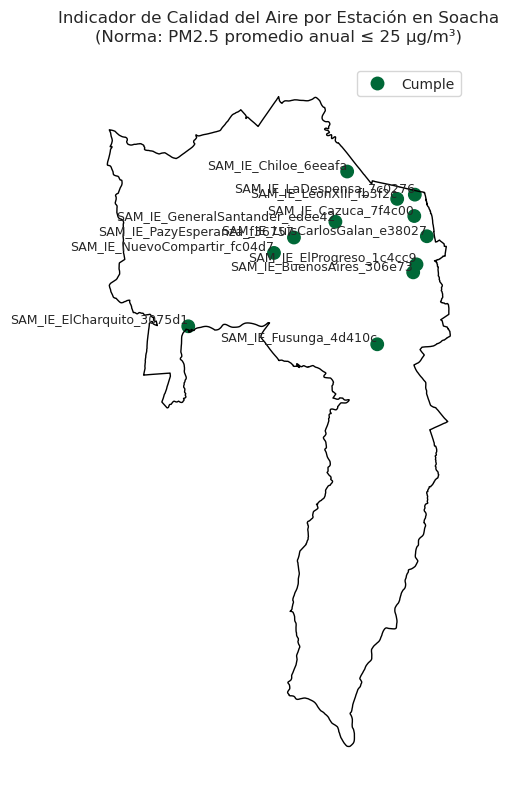

/tmp/ipykernel_902/1895332589.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gdf_est, x="Estación", y="PM25_mean", palette="RdYlGn_r")


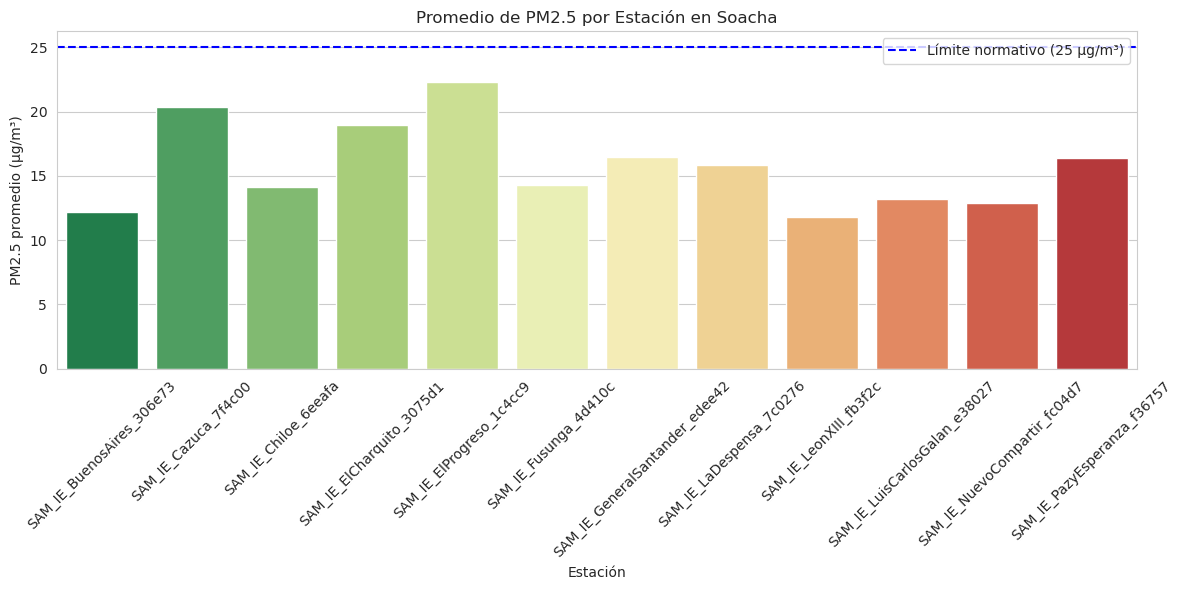

In [4]:
# =============================================================================
# Paso 1: Crear indicador por estación de calidad del aire
# =============================================================================

# Utilizando el GeoDataFrame de estación gdf_est que ya tiene la columna "PM25_mean"
# Definimos el indicador basado en la normativa (25 µg/m³ para promedio anual)
gdf_est["calidad"] = gdf_est["PM25_mean"].apply(lambda x: "Cumple" if x <= 25 else "No cumple")

# Mostramos la tabla con el indicador
print("Indicador de calidad del aire por estación:")
print(gdf_est[["Estación", "PM25_mean", "calidad"]].round(2))

# =============================================================================
# Paso 2: Visualizar el indicador en un mapa de puntos sobre el límite del municipio
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el contorno del municipio de Soacha (ya proyectado a EPSG:9377)
gdf_soacha.boundary.plot(ax=ax, color="black", linewidth=1)

# Graficar las estaciones, coloreándolas según el indicador de calidad "calidad".
# Usamos una paleta de colores que asigne, por ejemplo, tonos más verdes para "Cumple" y rojos para "No cumple".
gdf_est.plot(
    ax=ax, 
    column="calidad", 
    cmap="RdYlGn_r",  # Esta paleta asigna tonalidades: generalmente, el extremo "verde" se asocia a valores bajos (cumple) y el extremo "rojo" a valores altos (no cumple)
    markersize=80, 
    legend=True,
    categorical=True
)

# Agregar etiquetas de cada estación 

for x, y, label in zip(gdf_est.geometry.x, gdf_est.geometry.y, gdf_est["Estación"]):
    ax.text(x, y, label, fontsize=9, ha="right", va="bottom")

ax.set_title("Indicador de Calidad del Aire por Estación en Soacha\n(Norma: PM2.5 promedio anual ≤ 25 µg/m³)")
plt.axis("off")
plt.tight_layout()
plt.show()

# =============================================================================
# Paso 3: Graficamos un diagrama de barras para ver PM2.5 de cada estación junto con el umbral
# =============================================================================

plt.figure(figsize=(12, 6))
sns.barplot(data=gdf_est, x="Estación", y="PM25_mean", palette="RdYlGn_r")
plt.axhline(25, color="blue", linestyle="--", label="Límite normativo (25 µg/m³)")
plt.title("Promedio de PM2.5 por Estación en Soacha")
plt.xlabel("Estación")
plt.ylabel("PM2.5 promedio (µg/m³)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calidad  de  aire - Uso de Suelo,
En el  siguinte script se integra la capa de uso de suelo  

Valores de uso de suelo: ['RESIDENCIAL' 'ZONA AGRICOLA SOSTENIBLE' 'ZONA INSTITUCIONAL SERVICIOS'
 'ZONA INSTITUCIONAL 2 DE SERVICIOS ISS' 'PARQUE ACTIVIDAD ECONOMICA'
 'PARQUE METROPOLITANO' 'PLANTA DE TRATAMIENTO DE AGUAS RESIDUALES'
 'PRESERVACION AMBIENTAL' 'UNIDADES INTEGRALES DE DESARROLLO SOCIAL'
 'PROTECCION AMBIENTAL' 'AREA DE ACTIVIDAD MULTIPLE']


/tmp/ipykernel_902/855022.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


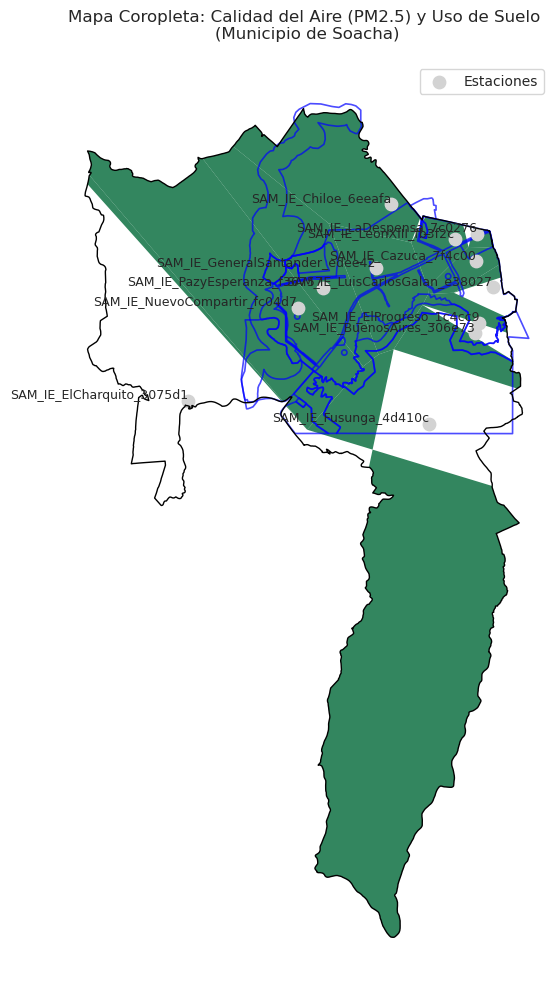

In [3]:
# =============================================================================
# Integrar la capa de Uso de Suelo al mapa
# =============================================================================

# Asumiendo que gdf_souelo ya fue cargado y reproyectado a EPSG:9377
# Si aún no se ha hecho, asegúrate de reproyectarlo:
gdf_suelo = gdf_suelo.to_crs(epsg=9377)

# Opcional: Se puede revisar los valores únicos o la distribución de la variable "uso_suelo"
print("Valores de uso de suelo:", gdf_suelo["USO_SUELO"].unique())

# Ahora, generamos el mapa coropleta que ya habíamos preparado (por ejemplo, con los polígonos Voronoi clasificados)
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar la capa de Voronoi de calidad del aire (ya recortados a Soacha)
gdf_voronoi_clip.plot(column="calidad", ax=ax, cmap="RdYlGn_r", legend=True,
                        legend_kwds={'title': "Calidad del Aire (PM2.5)", 'loc': 'upper right'},
                        edgecolor="none", alpha=0.8)

# Sobreponer la capa de Uso de Suelo: se puede dibujar con transparencia, utilizando un cmap propio o con borde.
# Por ejemplo, se muestra en azul claro (solo contorno o con relleno semitransparente)

gdf_suelo.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1.2, alpha=0.7, label="Uso de Suelo")


# Dibujar el límite del municipio de Soacha para referencia geográfica
gdf_soacha.boundary.plot(ax=ax, color="black", linewidth=1)

# Si además se desea mostrar las estaciones (puntos), se agregan:
gdf_est.plot(ax=ax, color="lightgray", markersize=80, label="Estaciones")
# Y opcionalmente, se pueden etiquetar algunas estaciones:
for x, y, label in zip(gdf_est.geometry.x, gdf_est.geometry.y, gdf_est["Estación"]):
    ax.text(x, y, label, fontsize=9, ha="right", va="bottom")

ax.set_title("Mapa Coropleta: Calidad del Aire (PM2.5) y Uso de Suelo \n(Municipio de Soacha)")
ax.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

 # Uso de polígonos de Voronoi

El script utiliza polígonos de Voronoi (a veces llamados polígonos de Thiessen) para aproximar la zona de influencia de cada estación de monitoreo. Esto se hace porque, a partir de datos puntuales (las ubicaciones de las estaciones), se busca asignar a cada una un área en la cual se asume que la medición realizada es representativa. De este modo, en lugar de tener datos aislados, se genera un “mapa” continuo que permite visualizar espacialmente cómo se distribuyen los niveles de PM2.5 en el municipio.  

En resumen, el uso de los polígonos de Voronoi en este contexto permite visualizar de forma intuitiva y geográficamente coherente qué zonas dentro de Soacha están en conformidad con la normativa ambiental o, por el contrario, requieren atención debido a niveles altos de contaminantes. Esto facilita la toma de decisiones, la identificación de áreas problemáticas y el diseño de estrategias de intervención basadas en la distribución espacial de la calidad del aire.

Retos: analisis espacio - tempora e  inclusión de capas Topograficas , Vial , fuentes fijas , densidad Vial  entre otros.  